In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-10 15:10:55.709597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 15:10:55.900204: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-10 15:10:59.226177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-10 15:10:59.226343: W tensorflow/strea

2.10.1


In [2]:
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2095, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2095 (delta 2), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2095/2095), 15.07 MiB | 31.81 MiB/s, done.
Resolving deltas: 100% (660/660), done.


In [3]:
!pip install split-folders 

In [4]:
import splitfolders
import os

In [5]:
path = "Sign-Language-Digits-Dataset/Dataset"

splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

Copying files: 2062 files [00:00, 5747.63 files/s]


In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 1438 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 320 images belonging to 10 classes.


In [8]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-10 15:11:19.956390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-10 15:11:19.971071: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-10 15:11:19.971179: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6afbe6836ba3): /proc/driver/nvidia/version does not exist
2023-09-10 15:11:19.986243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

574710816/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [9]:
##DEFINIMOS EL MODELO
num_classes = 10
epochs = 100

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

80134624/80134624 [==============================] - 1s 0us/step
22


In [10]:
from numpy.random import seed
tf.keras.utils.set_random_seed(42)# keras seed fixing
tf.random.set_seed(42)# tensorflow seed fixing

## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-02', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 3.5997 - accuracy: 0.1064
Epoch 1: accuracy improved from -inf to 0.10640, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 109s 2s/step - loss: 3.5997 - accuracy: 0.1064 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 3.4149 - accuracy: 0.1592
Epoch 2: accuracy improved from 0.10640 to 0.15925, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 105s 2s/step - loss: 3.4149 - accuracy: 0.1592 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 3.3249 - accuracy: 0.1885
Epoch 3: accuracy improved from 0.15925 to 0.18846, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 104s 2s/step - loss: 3.3249 - accuracy: 0.1885 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 3.1978 - accuracy: 0.2643
Epoch 4: accuracy improved from 0.18846 to 0.26426, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 104s 2s/step - loss: 3.1978 - accuracy: 0.2643 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - ETA: 0s - loss: 3.0288 - accuracy: 0.3227
Epoch 5: accuracy improved from 0.26426 to 0.32267, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 105s 2s/step - loss: 3.0288 - accuracy: 0.3227 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - ETA: 0s - loss: 2.8295 - accuracy: 0.3992
Epoch 6: accuracy improved from 0.32267 to 0.39917, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 108s 2s/step - loss: 2.8295 - accuracy: 0.3992 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - ETA: 0s - loss: 2.7119 - accuracy: 0.4318
Epoch 7: accuracy improved from 0.39917 to 0.43185, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 102s 2s/step - loss: 2.7119 - accuracy: 0.4318 - lr: 0.0010
Epoch 8/100
45/45 [==============================] - ETA: 0s - loss: 2.5559 - accuracy: 0.4868
Epoch 8: accuracy improved from 0.43185 to 0.48679, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 101s 2s/step - loss: 2.5559 - accuracy: 0.4868 - lr: 0.0010
Epoch 9/100
45/45 [==============================] - ETA: 0s - loss: 2.3707 - accuracy: 0.5702
Epoch 9: accuracy improved from 0.48679 to 0.57024, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 100s 2s/step - loss: 2.3707 - accuracy: 0.5702 - lr: 0.0010
Epoch 10/100
45/45 [==============================] - ETA: 0s - loss: 2.2624 - accuracy: 0.5939
Epoch 10: accuracy improved from 0.57024 to 0.59388, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 99s 2s/step - loss: 2.2624 - accuracy: 0.5939 - lr: 0.0010
Epoch 11/100
45/45 [==============================] - ETA: 0s - loss: 2.1293 - accuracy: 0.6391
Epoch 11: accuracy improved from 0.59388 to 0.63908, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 101s 2s/step - loss: 2.1293 - accuracy: 0.6391 - lr: 0.0010
Epoch 12/100
45/45 [==============================] - ETA: 0s - loss: 2.0016 - accuracy: 0.6815
Epoch 12: accuracy improved from 0.63908 to 0.68150, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 102s 2s/step - loss: 2.0016 - accuracy: 0.6815 - lr: 0.0010
Epoch 13/100
45/45 [==============================] - ETA: 0s - loss: 1.9060 - accuracy: 0.7295
Epoch 13: accuracy improved from 0.68150 to 0.72949, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 101s 2s/step - loss: 1.9060 - accuracy: 0.7295 - lr: 0.0010
Epoch 14/100
45/45 [==============================] - ETA: 0s - loss: 1.8345 - accuracy: 0.7538
Epoch 14: accuracy improved from 0.72949 to 0.75382, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 101s 2s/step - loss: 1.8345 - accuracy: 0.7538 - lr: 0.0010
Epoch 15/100
45/45 [==============================] - ETA: 0s - loss: 1.7573 - accuracy: 0.7796
Epoch 15: accuracy improved from 0.75382 to 0.77955, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 103s 2s/step - loss: 1.7573 - accuracy: 0.7796 - lr: 0.0010
Epoch 16/100
45/45 [==============================] - ETA: 0s - loss: 1.7056 - accuracy: 0.7997
Epoch 16: accuracy improved from 0.77955 to 0.79972, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 101s 2s/step - loss: 1.7056 - accuracy: 0.7997 - lr: 0.0010
Epoch 17/100
45/45 [==============================] - ETA: 0s - loss: 1.6320 - accuracy: 0.8157
Epoch 17: accuracy improved from 0.79972 to 0.81572, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 102s 2s/step - loss: 1.6320 - accuracy: 0.8157 - lr: 0.0010
Epoch 18/100
45/45 [==============================] - ETA: 0s - loss: 1.5503 - accuracy: 0.8547
Epoch 18: accuracy improved from 0.81572 to 0.85466, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 104s 2s/step - loss: 1.5503 - accuracy: 0.8547 - lr: 0.0010
Epoch 19/100
45/45 [==============================] - ETA: 0s - loss: 1.5318 - accuracy: 0.8561
Epoch 19: accuracy improved from 0.85466 to 0.85605, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 102s 2s/step - loss: 1.5318 - accuracy: 0.8561 - lr: 0.0010
Epoch 20/100
45/45 [==============================] - ETA: 0s - loss: 1.4970 - accuracy: 0.8602
Epoch 20: accuracy improved from 0.85605 to 0.86022, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 102s 2s/step - loss: 1.4970 - accuracy: 0.8602 - lr: 0.0010
Epoch 21/100
45/45 [==============================] - ETA: 0s - loss: 1.4655 - accuracy: 0.8818
Epoch 21: accuracy improved from 0.86022 to 0.88178, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 101s 2s/step - loss: 1.4655 - accuracy: 0.8818 - lr: 0.0010
Epoch 22/100
45/45 [==============================] - ETA: 0s - loss: 1.4697 - accuracy: 0.8783
Epoch 22: accuracy did not improve from 0.88178
45/45 [==============================] - 97s 2s/step - loss: 1.4697 - accuracy: 0.8783 - lr: 0.0010
Epoch 23/100
45/45 [==============================] - ETA: 0s - loss: 1.4723 - accuracy: 0.8776
Epoch 23: accuracy did not improve from 0.88178
45/45 [==============================] - 97s 2s/step - loss: 1.4723 - accuracy: 0.8776 - lr: 0.0010
Epoch 24/100
45/45 [==============================] - ETA: 0s - loss: 1.3745 - accuracy: 0.9110
Epoch 24: accuracy improved from 0.88178 to 0.91099, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 103s 2s/step - loss: 1.3745 - accuracy: 0.9110 - lr: 0.0010
Epoch 25/100
45/45 [==============================] - ETA: 0s - loss: 1.4206 - accuracy: 0.8971
Epoch 25: accuracy did not improve from 0.91099
45/45 [==============================] - 97s 2s/step - loss: 1.4206 - accuracy: 0.8971 - lr: 0.0010
Epoch 26/100
45/45 [==============================] - ETA: 0s - loss: 1.3793 - accuracy: 0.9047
Epoch 26: accuracy did not improve from 0.91099
45/45 [==============================] - 97s 2s/step - loss: 1.3793 - accuracy: 0.9047 - lr: 0.0010
Epoch 27/100
45/45 [==============================] - ETA: 0s - loss: 1.3496 - accuracy: 0.9145
Epoch 27: accuracy improved from 0.91099 to 0.91446, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 101s 2s/step - loss: 1.3496 - accuracy: 0.9145 - lr: 0.0010
Epoch 28/100
45/45 [==============================] - ETA: 0s - loss: 1.3502 - accuracy: 0.9152
Epoch 28: accuracy improved from 0.91446 to 0.91516, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 101s 2s/step - loss: 1.3502 - accuracy: 0.9152 - lr: 0.0010
Epoch 29/100
45/45 [==============================] - ETA: 0s - loss: 1.3218 - accuracy: 0.9193
Epoch 29: accuracy improved from 0.91516 to 0.91933, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 102s 2s/step - loss: 1.3218 - accuracy: 0.9193 - lr: 0.0010
Epoch 30/100
45/45 [==============================] - ETA: 0s - loss: 1.2902 - accuracy: 0.9325
Epoch 30: accuracy improved from 0.91933 to 0.93255, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 102s 2s/step - loss: 1.2902 - accuracy: 0.9325 - lr: 0.0010
Epoch 31/100
45/45 [==============================] - ETA: 0s - loss: 1.2929 - accuracy: 0.9277
Epoch 31: accuracy did not improve from 0.93255
45/45 [==============================] - 96s 2s/step - loss: 1.2929 - accuracy: 0.9277 - lr: 0.0010
Epoch 32/100
45/45 [==============================] - ETA: 0s - loss: 1.3279 - accuracy: 0.9172
Epoch 32: accuracy did not improve from 0.93255
45/45 [==============================] - 97s 2s/step - loss: 1.3279 - accuracy: 0.9172 - lr: 0.0010
Epoch 33/100
45/45 [==============================] - ETA: 0s - loss: 1.2687 - accuracy: 0.9416
Epoch 33: accuracy improved from 0.93255 to 0.94159, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 100s 2s/step - loss: 1.2687 - accuracy: 0.9416 - lr: 0.0010
Epoch 34/100
45/45 [==============================] - ETA: 0s - loss: 1.2704 - accuracy: 0.9409
Epoch 34: accuracy did not improve from 0.94159
45/45 [==============================] - 96s 2s/step - loss: 1.2704 - accuracy: 0.9409 - lr: 0.0010
Epoch 35/100
45/45 [==============================] - ETA: 0s - loss: 1.2625 - accuracy: 0.9451
Epoch 35: accuracy improved from 0.94159 to 0.94506, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 99s 2s/step - loss: 1.2625 - accuracy: 0.9451 - lr: 0.0010
Epoch 36/100
45/45 [==============================] - ETA: 0s - loss: 1.2275 - accuracy: 0.9492
Epoch 36: accuracy improved from 0.94506 to 0.94924, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 97s 2s/step - loss: 1.2275 - accuracy: 0.9492 - lr: 0.0010
Epoch 37/100
45/45 [==============================] - ETA: 0s - loss: 1.2518 - accuracy: 0.9471
Epoch 37: accuracy did not improve from 0.94924
45/45 [==============================] - 94s 2s/step - loss: 1.2518 - accuracy: 0.9471 - lr: 0.0010
Epoch 38/100
45/45 [==============================] - ETA: 0s - loss: 1.2494 - accuracy: 0.9409
Epoch 38: accuracy did not improve from 0.94924
45/45 [==============================] - 94s 2s/step - loss: 1.2494 - accuracy: 0.9409 - lr: 0.0010
Epoch 39/100
45/45 [==============================] - ETA: 0s - loss: 1.2406 - accuracy: 0.9492
Epoch 39: accuracy did not improve from 0.94924
45/45 [==============================] - 95s 2s/step - loss: 1.2406 - accuracy: 0.9492 - lr: 0.0010
Epoch 40/100
45/45 [==============================] - ETA: 0s - loss: 1.1804 - accuracy: 0.9597
Epoch 40: accuracy improved from 0.94924 to 0.95967, saving model to mod

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 98s 2s/step - loss: 1.1804 - accuracy: 0.9597 - lr: 2.0000e-04
Epoch 41/100
45/45 [==============================] - ETA: 0s - loss: 1.2066 - accuracy: 0.9548
Epoch 41: accuracy did not improve from 0.95967
45/45 [==============================] - 93s 2s/step - loss: 1.2066 - accuracy: 0.9548 - lr: 2.0000e-04
Epoch 42/100
45/45 [==============================] - ETA: 0s - loss: 1.1861 - accuracy: 0.9597
Epoch 42: accuracy did not improve from 0.95967
45/45 [==============================] - 95s 2s/step - loss: 1.1861 - accuracy: 0.9597 - lr: 2.0000e-04
Epoch 43/100
45/45 [==============================] - ETA: 0s - loss: 1.1789 - accuracy: 0.9611
Epoch 43: accuracy improved from 0.95967 to 0.96106, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 96s 2s/step - loss: 1.1789 - accuracy: 0.9611 - lr: 2.0000e-04
Epoch 44/100
45/45 [==============================] - ETA: 0s - loss: 1.1730 - accuracy: 0.9666
Epoch 44: accuracy improved from 0.96106 to 0.96662, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 96s 2s/step - loss: 1.1730 - accuracy: 0.9666 - lr: 2.0000e-04
Epoch 45/100
45/45 [==============================] - ETA: 0s - loss: 1.1640 - accuracy: 0.9673
Epoch 45: accuracy improved from 0.96662 to 0.96732, saving model to model-02


INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 97s 2s/step - loss: 1.1640 - accuracy: 0.9673 - lr: 2.0000e-04
Epoch 46/100
45/45 [==============================] - ETA: 0s - loss: 1.1711 - accuracy: 0.9583
Epoch 46: accuracy did not improve from 0.96732
45/45 [==============================] - 92s 2s/step - loss: 1.1711 - accuracy: 0.9583 - lr: 2.0000e-04
Epoch 47/100
45/45 [==============================] - ETA: 0s - loss: 1.1842 - accuracy: 0.9576
Epoch 47: accuracy did not improve from 0.96732
45/45 [==============================] - 95s 2s/step - loss: 1.1842 - accuracy: 0.9576 - lr: 2.0000e-04
Epoch 48/100
45/45 [==============================] - ETA: 0s - loss: 1.1870 - accuracy: 0.9597
Epoch 48: accuracy did not improve from 0.96732
45/45 [==============================] - 95s 2s/step - loss: 1.1870 - accuracy: 0.9597 - lr: 2.0000e-04
Epoch 49/100
45/45 [==============================] - ETA: 0s - loss: 1.1772 - accuracy: 0.9576
Epoch 49: accuracy did not improve from 0.96732
45/45 [=

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 101s 2s/step - loss: 1.1644 - accuracy: 0.9708 - lr: 8.0000e-06
Epoch 55/100
45/45 [==============================] - ETA: 0s - loss: 1.1665 - accuracy: 0.9652
Epoch 55: accuracy did not improve from 0.97079
45/45 [==============================] - 98s 2s/step - loss: 1.1665 - accuracy: 0.9652 - lr: 8.0000e-06
Epoch 56/100
45/45 [==============================] - ETA: 0s - loss: 1.1834 - accuracy: 0.9583
Epoch 56: accuracy did not improve from 0.97079
45/45 [==============================] - 96s 2s/step - loss: 1.1834 - accuracy: 0.9583 - lr: 8.0000e-06
Epoch 57/100
45/45 [==============================] - ETA: 0s - loss: 1.1645 - accuracy: 0.9666
Epoch 57: accuracy did not improve from 0.97079
45/45 [==============================] - 97s 2s/step - loss: 1.1645 - accuracy: 0.9666 - lr: 1.6000e-06
Epoch 58/100
45/45 [==============================] - ETA: 0s - loss: 1.1775 - accuracy: 0.9604
Epoch 58: accuracy did not improve from 0.97079
45/45 [

INFO:tensorflow:Assets written to: model-02/assets


INFO:tensorflow:Assets written to: model-02/assets


45/45 [==============================] - 100s 2s/step - loss: 1.1661 - accuracy: 0.9722 - lr: 1.0000e-06
Epoch 62/100
45/45 [==============================] - ETA: 0s - loss: 1.1509 - accuracy: 0.9680
Epoch 62: accuracy did not improve from 0.97218
45/45 [==============================] - 98s 2s/step - loss: 1.1509 - accuracy: 0.9680 - lr: 1.0000e-06
Epoch 63/100
45/45 [==============================] - ETA: 0s - loss: 1.1588 - accuracy: 0.9673
Epoch 63: accuracy did not improve from 0.97218
45/45 [==============================] - 97s 2s/step - loss: 1.1588 - accuracy: 0.9673 - lr: 1.0000e-06
Epoch 64/100
45/45 [==============================] - ETA: 0s - loss: 1.1664 - accuracy: 0.9673
Epoch 64: accuracy did not improve from 0.97218
45/45 [==============================] - 97s 2s/step - loss: 1.1664 - accuracy: 0.9673 - lr: 1.0000e-06
Epoch 65/100
45/45 [==============================] - ETA: 0s - loss: 1.1729 - accuracy: 0.9576
Epoch 65: accuracy did not improve from 0.97218
45/45 [

In [11]:
preds_test = model.predict(test_generator)

10/10 [==============================] - 7s 649ms/step


In [12]:
evaluate_test = model.evaluate(test_generator)

10/10 [==============================] - 7s 660ms/step - loss: 1.1601 - accuracy: 0.9719


In [13]:
evaluate_test

[1.1601026058197021, 0.971875011920929]

In [14]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 8, 7, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 7, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [15]:
y_real_test = test_generator.classes
y_real_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [16]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9625

In [17]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[32,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 30,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2, 30,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 32,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 29,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2, 29,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0, 31]])

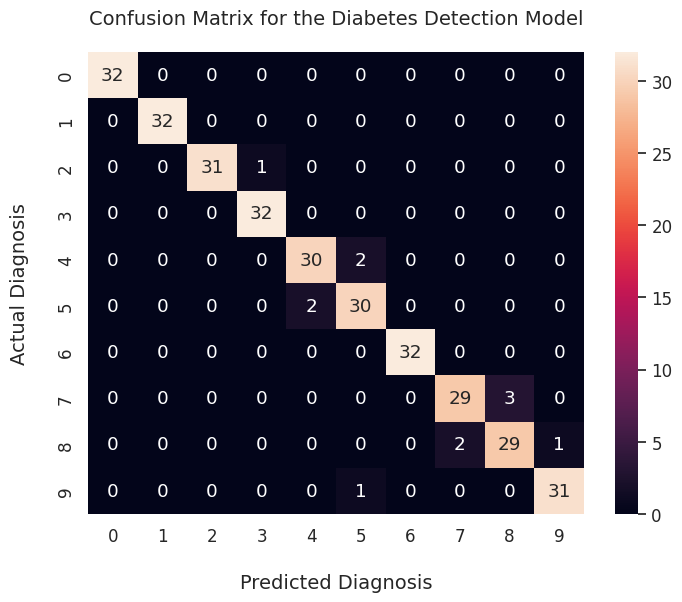

In [18]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [19]:
preds_val = model.predict(valid_generator)

10/10 [==============================] - 6s 554ms/step


In [20]:
evaluate_val = model.evaluate(valid_generator)

10/10 [==============================] - 7s 737ms/step - loss: 1.1858 - accuracy: 0.9671


In [21]:
evaluate_val

[1.185783863067627, 0.9671052694320679]

In [22]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [23]:
y_real_val = valid_generator.classes
y_real_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [24]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9736842105263158

In [25]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 29,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 29,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 29,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  1,  1, 29,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 31,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 28,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 31,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 30]])

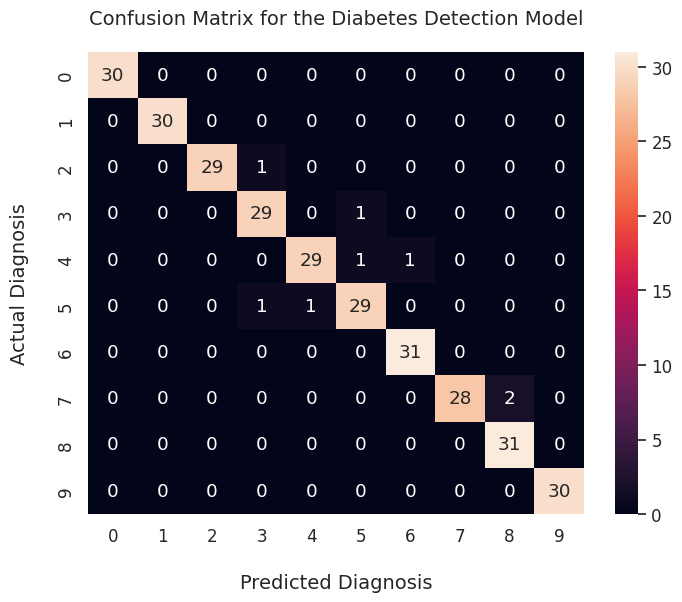

In [26]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()